# 자동차 제조 테스트 공정 시간 예측하기

## 분석 프로세스

데이터 출처: [Kaggle] https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/data   


**데이터 정보**  


|ID|테스트번호|
|:--:|:--:|
|y|테스트 시간|
|X1-X8|범주형 데이터|
|X10-X385|숫자형 데이터|


### 분석 목표 정의  
> 자동차 제조 테스트 공정 시간 예측하기

### 데이터 수집  
- 테스트별 걸린 시간
- 테스트 값

### 데이터 전처리  
- 결측값 여부
- Target Feature

### 모델 생성  
- 차원 축소 기법 (PCA, ICA, TSVD등) 별 모델링 후 최적 기법 탐색
- Stacked Regression 모델링

### 모델 평가  
- Feature Importance

- matplotlib 한글 깨짐 현상 해결  
> 셀 실행 후 런타임 재시작 필요

In [1]:
# matplotlib 한글깨짐 현상 해결
! apt-get update -qq
! apt-get install fonts-nanum* -qq

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = 'NanumGothic'
fe = fm.FontEntry(fname=path, name=font_name)
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': font_name})

Selecting previously unselected package fonts-nanum.
(Reading database ... 120899 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


## 데이터 준비를 위한 EDA 및 전처리

### 0. 데이터 불러오기

In [4]:
# 필요한 파이썬 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations

from sklearn import preprocessing
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF
from sklearn.cluster import FeatureAgglomeration

from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.linear_model import ElasticNet, LassoLarsCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.utils import check_array
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel

seed = 40

import warnings
warnings.filterwarnings('ignore')
color = sns.color_palette()
%matplotlib inline

In [6]:
train_df = pd.read_csv("/content/drive/MyDrive/MLStudy/Data_Anaylsis_And_Machine_Learning/08_car_manufacturing_test_time_prediction/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/MLStudy/Data_Anaylsis_And_Machine_Learning/08_car_manufacturing_test_time_prediction/test.csv")
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (4209, 378)
Test shape: (4209, 377)


In [7]:
train_df.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


> Feature 데이터
> 1. ID
> 2. y: target Feature
> 3. X0-X385

### 1. Target Feature
> Scatter Plot

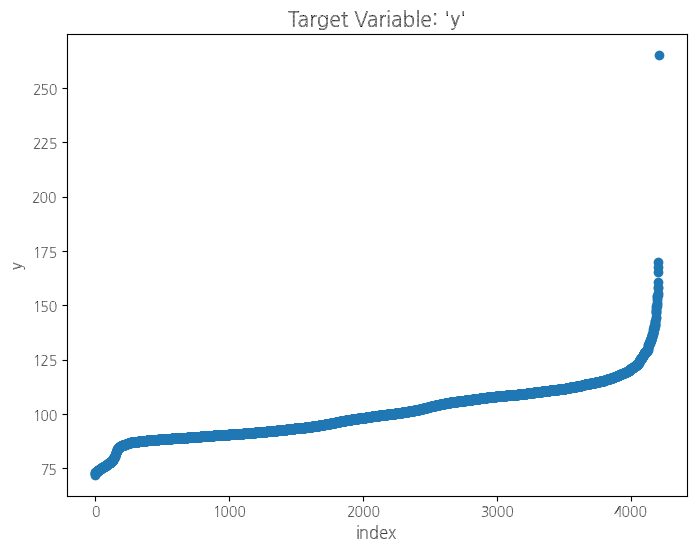

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.y.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Target Variable: 'y'", fontsize=15)
plt.show()

> Histogram

<Figure size 1200x800 with 0 Axes>

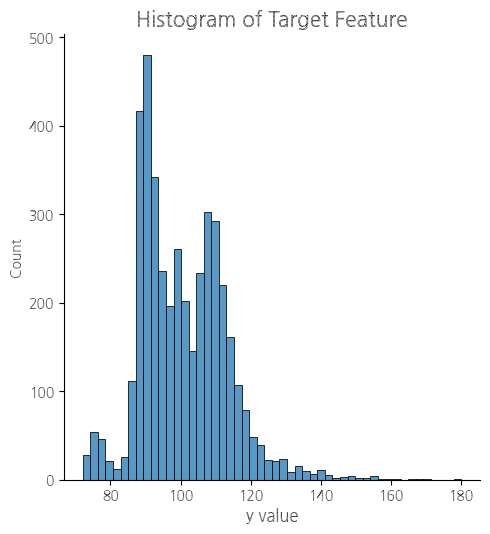

In [11]:
ulimit = 180
train_df['y'].loc[train_df['y'] > ulimit] = ulimit

plt.figure(figsize=(12, 8))
sns.displot(train_df.y.values, bins=50, kde=False)
plt.xlabel('y value', fontsize=12)
plt.title('Histogram of Target Feature', fontsize=15)
plt.show()

In [12]:
print(f"최소값: {min(train_df['y'].values)} 최대값: {max(train_df['y'].values)} 평균값: {train_df['y'].values.mean()} 표준편차: {train_df['y'].values.std()}")
print(f"180보다 큰 숫자들 개수: {np.sum(train_df['y'].values > 180)}")

최소값: 72.11 최대값: 180.0 평균값: 100.64904727963888 표준편차: 12.481281731120474
180보다 큰 숫자들 개수: 0


### 데이터 탐색

In [13]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,369
1,float64,1
2,object,8


In [14]:
dtype_df.loc[:10, :]

,Count,Column Type
0,ID,int64
1,y,float64
2,X0,object
3,X1,object
4,X2,object
5,X3,object
6,X4,object
7,X5,object
8,X6,object
9,X8,object


#### 결측값

In [16]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count'] > 0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


In [18]:
cols = [c for c in train_df.columns if 'X' in c]
print('Number of features:', len(cols))
print("Feature types:")
train_df[cols].dtypes.value_counts()

Number of features: 376
Feature types:


int64     368
object      8
dtype: int64

In [37]:
counts = [[], [], []]
for c in cols:
  typ = train_df[c].dtype
  uniq = len(np.unique(train_df[c]))
  if uniq == 1:
    counts[0].append(c)
  elif uniq == 2 and typ == np.int64:
    counts[1].append(c)
  else:
    counts[2].append(c)

print(f"Feature 값이 1개인 경우: {len(counts[0])}\nFeature 값이 2개인 경우: {len(counts[1])}\n범주형 Feature인 경우: {len(counts[2])}")
print("Feature 값이 1개인 경우: ", counts[0])
print("범주형 Feature인 경우: ", counts[2])

Feature 값이 1개인 경우: 12
Feature 값이 2개인 경우: 356
범주형 Feature인 경우: 8
Feature 값이 1개인 경우:  ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']
범주형 Feature인 경우:  ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']


In [31]:
unique_values_dict = {}
for col in train_df.columns:
  if col not in ["ID", 'y', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']:
    unique_value = str(np.sort(train_df[col].unique()).tolist())
    tlist = unique_values_dict.get(unique_value, [])
    tlist.append(col)
    unique_values_dict[unique_value] = tlist[:]
for unique_val, columns in unique_values_dict.items():
  print("컬럼에 존재하는 유일한 값들:", unique_val)   # 유일한 값이 1개이면 의미 없는 피쳐
  print(columns)

컬럼에 존재하는 유일한 값들: [0, 1]
['X10', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X132', 'X133', 'X134', 'X135', 'X136', 'X137', 'X138', 'X139', 'X140', 'X141', 'X142', 'X143', 'X144', 'X145', 'X146', 'X147', 'X148

#### 범주형 Features

In [32]:
cat_feat = counts[2]
train_df[cat_feat].head()

,X0,X1,X2,X3,X4,X5,X6,X8
0,k,v,at,a,d,u,j,o
1,k,t,av,e,d,y,l,o
2,az,w,n,c,d,x,j,x
3,az,t,n,f,d,x,l,e
4,az,v,n,f,d,h,d,n


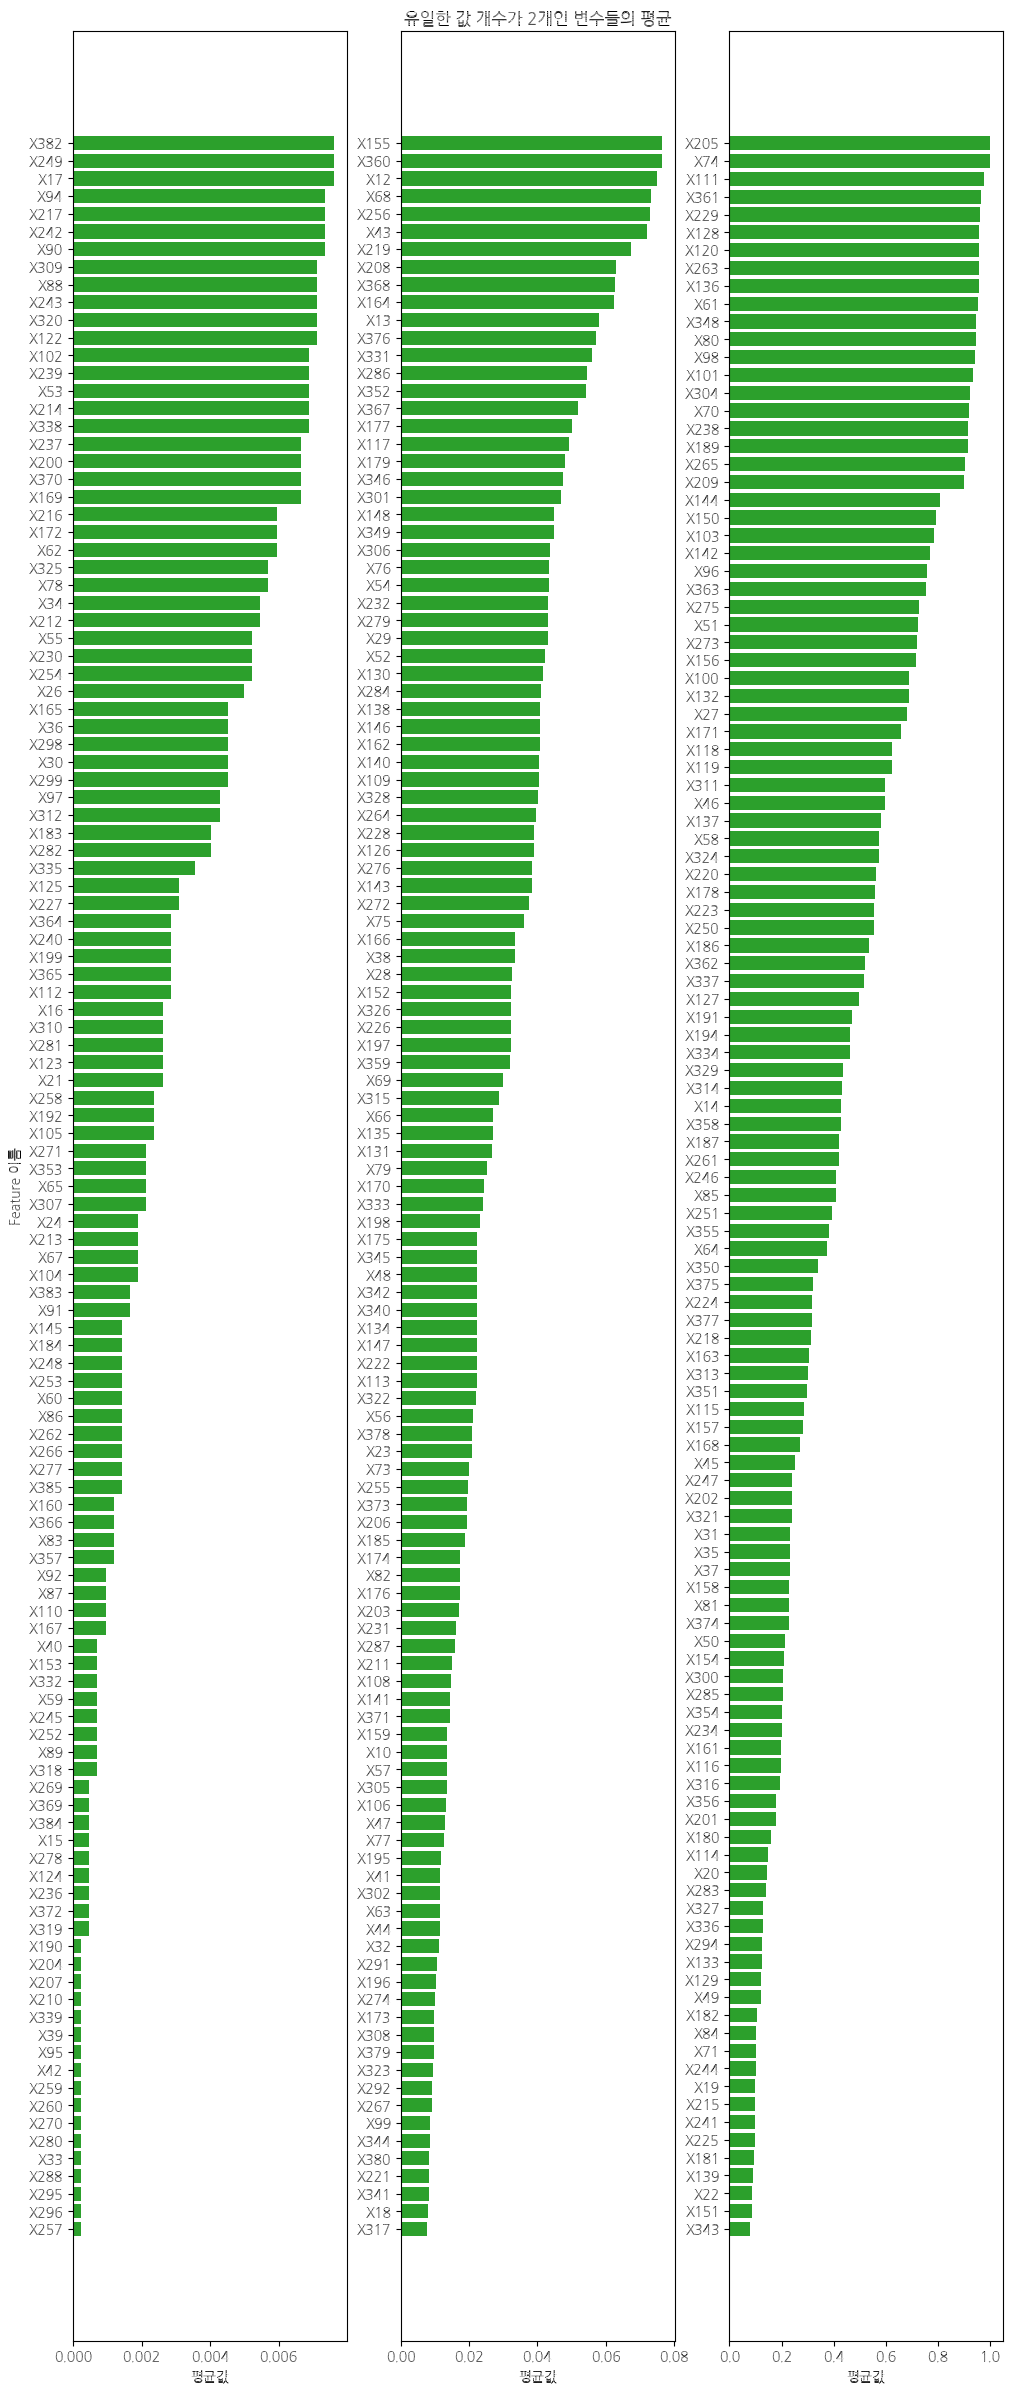

In [42]:

binary_means = [np.mean(train_df[c]) for c in counts[1]]
binary_names = np.array(counts[1])[np.argsort(binary_means)]
binary_means = np.sort(binary_means)

fig, ax = plt.subplots(1, 3, figsize=(12, 30))
ax[0].set_ylabel('Feature 이름')
ax[1].set_title('유일한 값 개수가 2개인 변수들의 평균')
for i in range(3):
  names, means = binary_names[i*119:(i+1)*119], binary_means[i*119:(i+1)*119]
  ax[i].barh(range(len(means)), means, color=color[2])
  ax[i].set_xlabel('평균값')
  ax[i].set_yticks(range(len(means)))
  ax[i].set_yticklabels(names, rotation="horizontal")
plt.show()